In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
import plotly.express as px # type: ignore
from sklearn.decomposition import PCA
import os

sns.set_theme(rc={'figure.figsize':(5,3)})

## data_cleaning

### fncl

In [21]:
tba = 'FNCL'

In [16]:
OAS_BLOOM = pd.read_csv(f"e://ehz/data/mbs/{tba}/mbs_oas.csv", index_col=0, parse_dates=True)
OAS_BLOOM.columns = [2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 1.5, 2, 7]
ALL_CPNS = np.arange(1.5, 7.5, 0.5)
OAS_BLOOM = OAS_BLOOM[ALL_CPNS]
OAS_BLOOM.to_csv(f"Data/{tba}/OAS_vs_TREAS.csv")

TBAS_PRICES = pd.read_csv(f"e://ehz/data/mbs/{tba}/mbs.csv", index_col=0, parse_dates=True).dropna(how="all")
d1 = pd.to_datetime('01/22/2021')
TBAS_PRICES.loc[: d1, 'FNCL 2.0 N Mtge'] = np.nan


d1 = pd.to_datetime('06/12/2012')
d2 = pd.to_datetime('02/11/2020')#d - pd.DateOffset(years=1)
TBAS_PRICES.loc[d1:d2, 'FNCL 7.0 N Mtge'] = np.nan
TBAS_PRICES.to_csv(f"Data/{tba}/GENERIC_TBAS.csv")

In [ ]:
sub_tba = TBAS_PRICES.tail(11)[[f'FNCL {c} N Mtge' for c in [2.0,2.5,3.0,4.5,7.0]]]

### G2SF

In [106]:
tba = 'G2SF'
if not os.path.isdir(f"Data/{tba}") : 
    os.mkdir(f"Data/{tba}")

In [107]:
TBAS_PRICES = pd.read_csv(f"e://ehz/data/mbs/{tba}/mbs.csv", index_col=0, parse_dates=True).dropna(how="all")


d1 = pd.to_datetime('06/12/2012')
d2 = pd.to_datetime('01/01/2023')
TBAS_PRICES.loc[d1:d2, f'{tba} 7.0 N Mtge'] = np.nan

TBAS_PRICES.drop(columns = [f'{tba} {c} N Mtge'for c in [1.5, 7.5]], inplace = True)
TBAS_PRICES.to_csv(f"Data/{tba}/GENERIC_TBAS.csv")

OAS_BLOOM = pd.read_csv(f"e://ehz/data/mbs/{tba}/mbs_oas.csv", index_col=0, parse_dates=True)
OAS_BLOOM.columns = OAS_BLOOM.columns.map(lambda x: float(x.split(' ')[0][-4:-1])/10)
OAS_BLOOM = OAS_BLOOM[np.arange(2,7.5, 0.5)]
OAS_BLOOM.to_csv(f"Data/{tba}/OAS_vs_TREAS.csv")

## data viz

In [108]:
OAS_BLOOM = pd.read_csv(f"Data/{tba}/OAS_vs_TREAS.csv", index_col=0, parse_dates=True)
OAS_BLOOM.columns = OAS_BLOOM.columns.map(float)

TBAS_PRICES = pd.read_csv(f"Data/{tba}/GENERIC_TBAS.csv", index_col=0, parse_dates=True).dropna(how="all")
TBAS_PRICES.columns = TBAS_PRICES.columns.map(lambda x: float(x.split()[1]))

In [6]:
dic = {
    2: 'wrong prices even though oas exists. manually corrected',
    6: 'correct prices, wrong oas constant in 2018-2023',
    6.5: 'correct prices missing oas',
    7: 'empty oas untill sep 2023; wrong prices 2013-2023; very volatile prices 2010-2013',
    7.5 : 'same as 7, no oas'
}

# conclusion : work with 2 -> 6.5 included

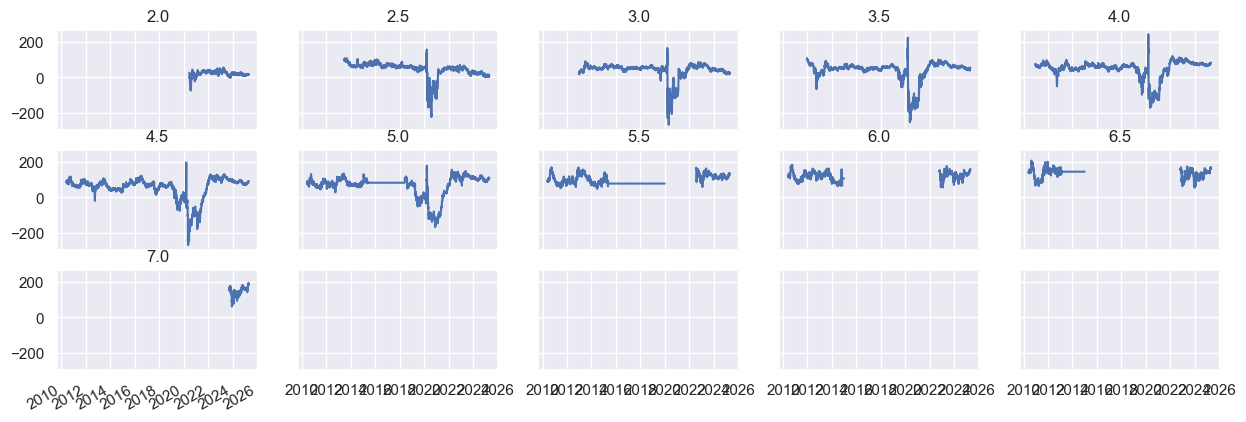

In [110]:
cpn_list = TBAS_PRICES.columns
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15,5), sharex=True, sharey=True)
axs = axs.flatten()
for i, c in enumerate(cpn_list):
    ax = axs[i]
    #TBAS_PRICES[c].plot(ax=ax)
    OAS_BLOOM[c].plot(ax=ax)
    ax.set_title(f'{c}')

## backtest

In [2]:
def get_data(tba, model, ALL_CPNS, oas_bloom_filter=False):


    OAS = pd.read_csv(f'Data/{tba}/{model}/OAS.csv', index_col=0, parse_dates=True, dayfirst=False)
    OAS.columns = OAS.columns.map(float)
    OAS = OAS[ALL_CPNS]

    if oas_bloom_filter :

        OAS_BLOOM = pd.read_csv(f"Data/{tba}/OAS_vs_TREAS.csv", index_col=0, parse_dates=True)
        OAS_BLOOM.columns = OAS_BLOOM.columns.map(float)
        OAS_BLOOM = OAS_BLOOM[ALL_CPNS]

        OAS = OAS.where(OAS_BLOOM.notna())
        OAS.dropna(how='all', inplace=True)
    

     
    TBAS_PRICES = pd.read_csv(f"Data/{tba}/GENERIC_TBAS.csv", index_col=0, parse_dates=True).dropna(how="all")
    TBAS_PRICES.columns = TBAS_PRICES.columns.map(lambda x: float(x.split()[1]))
    TBAS_PRICES = TBAS_PRICES[ALL_CPNS]
    TBAS_PRICES = TBAS_PRICES.loc[OAS.index]

    Durations = pd.read_csv(f'Data/{tba}/{model}/Durations.csv', index_col=0, parse_dates=True)
    Durations.columns = Durations.columns.map(float) 
    Durations = Durations[ALL_CPNS]
    Durations = Durations.loc[OAS.index]

    return TBAS_PRICES, OAS, Durations


def assign_weights(x, durations = None, equiweights = True, epsilon=0.3, holding_period=0):
    """
    """

    weights = pd.Series(0.0, index=x.index)
    
    # Get the indices of the three highest OAS
    three_highest = x.nlargest(3).index
    # Get the index of the lowest OAS
    lowest = x.idxmin()
    three_lowest = x.nsmallest(3).index

    # Compute the adjusted weight for the lowest OAS
    if  not equiweights : 
        weights[three_highest] = 1/3/durations[three_highest]
        weights[lowest] = -1/durations[lowest]

    else : 

        # Assign 1/3 to the three highest OAS
        weights[three_highest] = np.array([1/3, 1/3, 1/3])
        weights[lowest] =  -durations[three_highest].dot(weights[three_highest])/ durations[lowest]
        #weights[three_lowest] = -np.array([1/3, 1/3, 1/3])
    return weights



# Global variables to store previous rankings
prev_top3 = None
prev_bottom3 = None
hold_counter = None  

def assign_weights_(x, durations = None, equiweights = True, epsilon=0.3, holding_period=0):
    """
    Assigns weights to securities based on OAS residuals, while reducing unnecessary trades.

    - Uses `epsilon` to avoid ranking changes when OAS differences are small.
    - Enforces a minimum holding period (`holding_period`).
    - Reduces transaction costs by avoiding rebalancing due to small shifts.

    Parameters:
    - x: pd.Series, OAS residuals for each security.
    - epsilon: float, threshold for ignoring small OAS ranking changes.
    - holding_period: int, minimum number of periods to hold an asset before rebalancing.

    Returns:
    - pd.Series, updated weights.
    """
    global prev_top3, prev_bottom3, hold_counter  

    # Initialize weights to zero
    weights = pd.Series(0.0, index=x.index)

    # Sort OAS residuals
    sorted_x = x.sort_values(ascending=False)
    
    # Identify top 3 (cheapest) and bottom 3 (most expensive)
    top3 = sorted_x.index[:3]
    bottom3 = sorted_x.index[-3:]

    # If first run, initialize previous rankings and holding counter
    if prev_top3 is None or prev_bottom3 is None:
        prev_top3, prev_bottom3 = top3, bottom3
        hold_counter = pd.Series(0, index=x.index)
        weights[top3] = 1/3
        weights[bottom3] = -1/3
        return weights

    # Check if ranking changes are significant
    ranking_changed = False

    for asset in top3:
        if asset not in prev_top3:
            # Check if its OAS is significantly different from the previous third-ranked asset
            if abs(x[asset] - x[prev_top3[-1]]) > epsilon:
                ranking_changed = True

    for asset in bottom3:
        if asset not in prev_bottom3:
            # Check if its OAS is significantly different from the previous third-ranked asset
            if abs(x[asset] - x[prev_bottom3[-1]]) > epsilon:
                ranking_changed = True

    # Enforce holding period: Only allow changes if ranking has changed significantly
    if ranking_changed:
        for asset in x.index:
            if hold_counter[asset] < holding_period:
                weights[asset] = 0  # Maintain previous position if within holding period
                hold_counter[asset] += 1
            else:
                weights[top3] = 1/3
                weights[bottom3] = -1/3
                hold_counter[asset] = 0  # Reset hold counter if rebalanced
    else:
        # Keep previous weights if no significant ranking change
        weights[prev_top3] = 1/3
        weights[prev_bottom3] = -1/3

    # Update previous rankings for next period
    prev_top3, prev_bottom3 = top3, bottom3

    return weights



def get_acp_res_oas_1(OAS_df, n_components,
                    training_window = 200, prediction_window =20, standardize=True):
    OAS_mean = OAS_df.mean()
    OAS_std = OAS_df.std()
    OAS_normalized = (OAS_df - OAS_mean) / OAS_std
    OAS_normalized = OAS_df
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(OAS_normalized)

    # Create DataFrame for PCA components
    pca_components = pd.DataFrame(pca_transformed, index=OAS_df.index, columns=[f"PCA_{i+1}" for i in range(n_components)])

    oas_pca = pca.inverse_transform(pca_components)
    oas_pca.columns = (OAS_df.columns)
    #oas_pca = oas_pca*OAS_std + OAS_mean
    RES_OAS = (OAS_df - oas_pca)
    RES_OAS = RES_OAS.where(OAS_df.notna())
    return RES_OAS


def get_acp_res_oas_2(data, n_components,
                    training_window = 200, prediction_window =20, standardize=True):
    """
    Compute rolling PCA residual OAS (RES_OAS) on the given dataset with optional standardization.
    
    PCA is fit on a rolling training window (of length `training_window`) and then applied to the 
    subsequent `prediction_window` to compute out-of-sample residuals. After each prediction window, 
    the training window slides forward by the length of the prediction window (no future data is used 
    in any PCA fit).

    Parameters:
    - data: pd.DataFrame, the input dataset (indexed by time, columns are features/OAS series).
    - training_window: int, number of periods in each PCA training window (e.g., 252 trading days for 1 year).
    - prediction_window: int, number of periods in each prediction window (e.g., 21 trading days for 1 month).
    - standardize: bool, whether to standardize data (Z-score normalization) before applying PCA.
    
    Returns:
    - pd.DataFrame containing the aggregated residuals (RES_OAS) for each prediction window, indexed by time.
      The residuals DataFrame has no values for the initial training period (since those points were used for 
      training and not for out-of-sample prediction).
    """
    residuals_list = []  # To store residuals from each prediction window

    n = len(data)
    for train_start in range(0, n - training_window - prediction_window + 1, prediction_window):
        # Define training & prediction windows
        train_end = train_start + training_window
        pred_end = train_end + prediction_window
        
        train_data = data.iloc[train_start:train_end]
        pred_data  = data.iloc[train_end:pred_end]

        # Standardization (if enabled)
        if standardize:
            mean_train = train_data.mean()
            std_train = train_data.std().replace(0, 1)  # Avoid division by zero
            train_data_std = (train_data - mean_train) / std_train
            pred_data_std  = (pred_data - mean_train) / std_train  # Apply same mean/std to prediction window
        else:
            train_data_std = train_data
            pred_data_std  = pred_data

        # Fit PCA on training window
        pca = PCA(n_components=n_components)
        pca.fit(train_data_std)

        # Transform & reconstruct prediction data
        pred_scores = pca.transform(pred_data_std)
        pred_reconstructed = pca.inverse_transform(pred_scores)

        pred_reconstructed = pd.DataFrame(pred_reconstructed, index=pred_data.index, columns=data.columns)

        # Denormalize PCA-reconstructed data if standardization was applied
        if standardize:
            pred_reconstructed = (pred_reconstructed * std_train) + mean_train

        # Compute residuals (actual - reconstructed)
        res_df = pred_data - pred_reconstructed

        residuals_list.append(res_df)

    # Concatenate all residuals across time
    residuals_all = pd.concat(residuals_list)
    return residuals_all


def get_acp_res_oas_3(data, n_components,
                    training_window = 200, prediction_window =20, standardize=True):
    """
    Compute rolling PCA residual OAS (RES_OAS) on the given dataset with an expanding window approach.

    PCA is initially fit on `training_window` length data, but after each `prediction_window`, the 
    training data expands to include all past data (never forgetting previous values).

    Parameters:
    - data: pd.DataFrame, the input dataset (indexed by time, columns are features/OAS series).
    - training_window: int, number of periods in the initial PCA training window (e.g., 252 trading days for 1 year).
    - prediction_window: int, number of periods in each prediction window (e.g., 21 trading days for 1 month).
    - standardize: bool, whether to standardize data (Z-score normalization) before applying PCA.
    - n_components: int, number of PCA components to use.
    
    Returns:
    - pd.DataFrame containing the aggregated residuals (RES_OAS) for each prediction window, indexed by time.
      The residuals DataFrame has no values for the initial training period (since those points were used for 
      training and not for out-of-sample prediction).
    """
    residuals_list = []  # Store residuals
    n = len(data)

    # Start with the initial training window
    train_end = training_window

    while train_end + prediction_window <= n:
        pred_end = train_end + prediction_window
        
        # Expanding window: Train on all past data up to `train_end`
        train_data = data.iloc[:train_end]
        pred_data  = data.iloc[train_end:pred_end]

        # Standardization (if enabled)
        if standardize:
            mean_train = train_data.mean()
            std_train = train_data.std().replace(0, 1)  # Avoid division by zero
            train_data_std = (train_data - mean_train) / std_train
            pred_data_std  = (pred_data - mean_train) / std_train  # Apply same mean/std to prediction window
        else:
            train_data_std = train_data
            pred_data_std  = pred_data

        # Fit PCA on all past data (expanding window)
        pca = PCA(n_components=n_components)
        pca.fit(train_data_std)

        # Transform & reconstruct prediction data
        pred_scores = pca.transform(pred_data_std)
        pred_reconstructed = pca.inverse_transform(pred_scores)

        # Convert to DataFrame for alignment
        pred_reconstructed = pd.DataFrame(pred_reconstructed, index=pred_data.index, columns=data.columns)

        # Denormalize if standardization was applied
        if standardize:
            pred_reconstructed = (pred_reconstructed * std_train) + mean_train

        # Compute residuals (actual - reconstructed)
        res_df = pred_data - pred_reconstructed

        residuals_list.append(res_df)

        # Expand the training window
        train_end += prediction_window

    # Concatenate all residuals across time
    residuals_all = pd.concat(residuals_list)
    return residuals_all

mr_methods = [lambda x: x, get_acp_res_oas_1, get_acp_res_oas_2, get_acp_res_oas_3]

def compute_backtest(
        tba, model, ALL_CPNS, lissage, bid_to_mid, equiweights, MR , n_components=1,   
        verbose = True, oas_bloom_filter = False, training_window=200, prediction_window = 20,
        standardize = True, compare_with='DATA_SAMY copy'
        ):
    
    
    TBAS_PRICES, OAS, Durations = get_data(tba, model, ALL_CPNS, oas_bloom_filter)

    # Apply assign_weights along the rows (axis=1) of the OAS DataFrame or the RES_oas 
    signal = OAS
    if MR >0 :
        OAS = OAS.dropna()
        method = mr_methods[MR]
        signal = method(OAS, n_components,
                        training_window=training_window, 
                        prediction_window=prediction_window,
                        standardize=standardize,
                        ) 
        #signal = get_acp_res_oas(OAS,n_components) 

    #W = signal.apply(lambda row: assign_weights(row, Durations.loc[row.name], equiweights), axis=1)
    W = pd.DataFrame(0.0, index=signal.index, columns=signal.columns)  # Initialize weights DataFrame

    for i in range(len(signal)):
        W.iloc[i] = assign_weights(signal.iloc[i], Durations.iloc[i], equiweights)  # Apply the function row-by-row

    

    TBAS_PRICES = TBAS_PRICES.loc[W.index]

    # Smooth the weights using a rolling average over the past 10 days
    W_smoothed = W.rolling(window=lissage, min_periods=lissage).mean()
    # Calculate daily P&L of the strategy
    PnL = (TBAS_PRICES.diff() * W_smoothed.shift(1)).sum(axis=1)
    # Calculate transaction costs due to changes in weights
    weight_changes = W_smoothed.diff().abs()  # Absolute changes in smoothed weights
    transaction_costs = (weight_changes * bid_to_mid).sum(axis=1)
    # Adjust P&L for transaction costs
    PnL_net = PnL - transaction_costs

    if verbose : 

        result = pd.read_csv(f'Data/{tba}/{compare_with}/oas_result_global_2010_2024_with_pnl.csv', index_col=0, parse_dates=True)
        result_samy = result['Cumulative_PnL'].dropna()
        sharpe_ratio = PnL.mean() / PnL.std() * np.sqrt(252)  # Annualized
        sharpe_pnl_net = PnL_net.mean() / PnL_net.std() * np.sqrt(252)
        yearly_pnl = PnL_net.groupby(PnL_net.index.map(lambda x:x.year)).sum().mean()
        yearly_vol = PnL_net.groupby(PnL_net.index.map(lambda x:x.year)).sum().std()

        # Display results
        performance_df = pd.DataFrame({
            "Sharpe Ratio": [sharpe_ratio],
            "Sharpe Ratio net": [sharpe_pnl_net],
            "Avg Yearly PnL": [yearly_pnl],
            "Yearly Volatility": [yearly_vol]
            
        })
        display(performance_df)
        PnL_cumsum = PnL.cumsum()
        PnL_net_cumsum = PnL_net.cumsum()


        #"PnL": PnL_cumsum
        fig = px.line(
            pd.DataFrame({"PnL_net": PnL_net_cumsum, "PnL_samy": result_samy}),
            title="Cumulative P&L vs Net P&L",
            labels={"value": "Cumulative P&L", "index": "Date"}
        )
        fig.update_layout(xaxis_title="Date", yaxis_title="Cumulative P&L")
        fig.show()
        return PnL_net, W_smoothed

    else : 
        sharpe_pnl_net = PnL_net.mean() / PnL_net.std() * np.sqrt(252)
        return sharpe_pnl_net

In [39]:
tba = 'FNCL'
model = 'DATA_SAMY'
compare_with = 'DATA_SAMY'
ALL_CPNS = np.arange(2, 7.5, 0.5)
bid_to_mid = 1/32
equiweights = True
MR = 0
n_components = 1
oas_bloom_filter = False

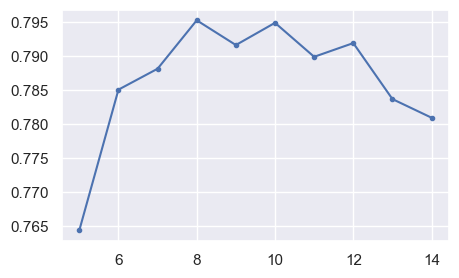

In [67]:
lissages = np.arange(5,15, 1)
verbose = False
s1 = [compute_backtest(
        tba, model, ALL_CPNS, lissage, bid_to_mid, equiweights, MR , 
        n_components, verbose, oas_bloom_filter) for lissage in lissages]

plt.plot(lissages, s1, marker='.')

In [40]:
lissage = 10
verbose = True
PnL_net, W = compute_backtest(
      tba, model, ALL_CPNS, lissage, bid_to_mid, equiweights, MR , 
      n_components, verbose, oas_bloom_filter, compare_with=compare_with)

,Sharpe Ratio,Sharpe Ratio net,Avg Yearly PnL,Yearly Volatility
0,0.822942,0.671368,2.550369,3.615012


In [28]:
TBAS_PRICES, OAS, Durations = get_data(tba, model, ALL_CPNS, oas_bloom_filter)

<Axes: xlabel='Dates'>

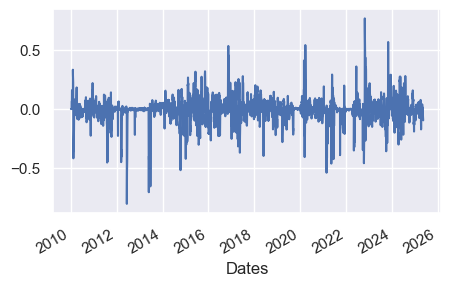

In [38]:
(Durations*W).sum(axis=1).plot()

<Axes: xlabel='Dates'>

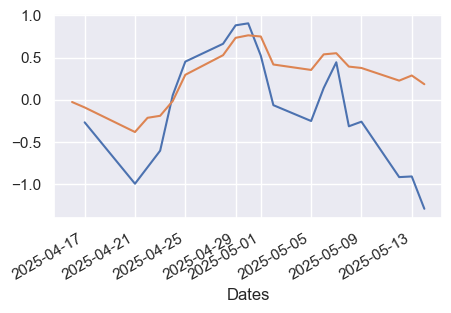

In [37]:
TBAS_PRICES.tail(20)[2].diff().cumsum().plot()
PnL_net.tail(20).cumsum().plot()

In [8]:
PnL_net.loc[pd.to_datetime('01/01/2025'):pd.to_datetime('03/01/2025')].sum()

np.float64(1.1739496142284094)